### 2020 NORTHERN TERRITORY ELECTION SEAT BY SEAT ANALYSIS

In [496]:
#libraries
import requests
from bs4 import BeautifulSoup, Tag
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import re

In [497]:
# EACH ELECTION NEEDS ITS OWN LIST OF SEATS 
# for example, "stuart" no longer exists

seats2020 = ["arafura", "araluen", "arnhem", "barkly", "blain", "braitling", "brennan", "casuarina", "daly", 
         "drysdale", "fannie-bay", "fong-lim", "goyder",  "gwoja", "johnston", "karama", "katherine", "mulka", "namatjira", 
         "nelson", "nightcliff", "port-darwin", "sanderson", "spillett", "wanguri",]

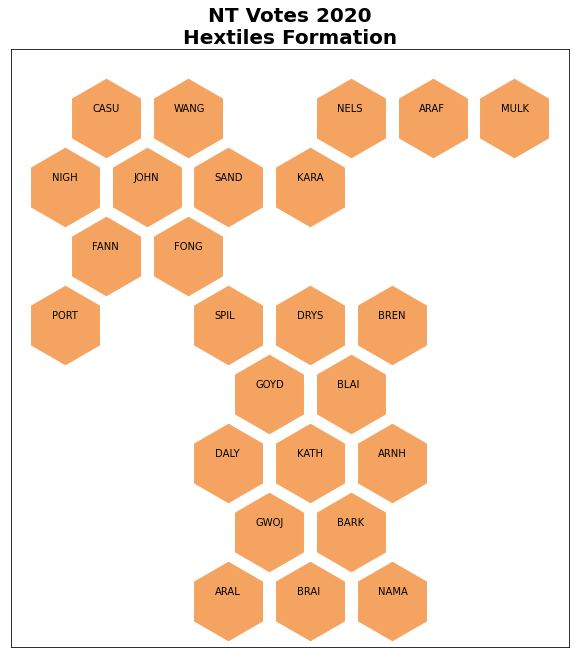

In [498]:
### import the position codes for our hextiles graph

hex2020 = pd.read_csv('Hex2020.csv')

# to make the EMPTY HEXTILES PLOT below
fig, ax = plt.subplots()

plt.title('NT Votes 2020\nHextiles Formation', fontdict={'fontsize': 20, 'fontweight': 'bold'})

plt.rcParams["figure.figsize"] = (10,11)

ax.scatter(hex2020['x'], hex2020['y'], marker='h', s=6150, c='sandybrown')
plt.xlim(0.2, 4.3)
plt.ylim(-13, 13) 
plt.xticks([])
plt.yticks([])

for i, point in hex2020.iterrows():
        plt.text(point['x'] - 0.1, point['y']+.3, str(point['Seat'][0:4].upper()))

In [501]:
# SCRAPE THE NTEC SITE FOR DATA AND COLLATE IT

def getVotes(url, seat):
    
    #create empty dataframe, to fill as we go through
    df = pd.DataFrame()

    # scrape the data from webpage
    URL = url
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    
    # refine the data you have

    results = soup.find(id=re.compile('content_container_'))  # this is the main container. it has a different identifier on the end of it on each page

    tables = results.find_all('table')                       # there isn't good ids and classes to look for, so lets break it down by table

    
    #get the summary table 
    # T for table

    summaryT = tables[0]
    
    
    # Break it up into rows
    rows = summaryT.find_all('tr')


    #GET HEADER NAMES
    headerR = rows[0]           # R for row

    # A. make a new empty list...
    column_names = []

    # B. find the header of the table...
    ths = summaryT.find_all('th')

    # C. go through the header...
    for th in ths:
        l = th.contents             # find all the names...

        for i in l:                 # this step only here because it's not recognising l[0]
            column_names.append(i)      # ... and append it to the list


    # GET CANDIDATE INFO

    n = len(rows)

    candidates = {}

    for i in range(1,n-4):            # there are 4 rows of summary info which aren't candidates

        tds = rows[i].find_all('td')

        l = [td.contents[0] for td in tds]

        candidates[i] = {column_names[0]:l[0], column_names[1]:l[1], column_names[2]:l[2], column_names[3]:l[3], column_names[4]:l[4]}


    #print(candidates)


    df = pd.DataFrame(candidates)       

    df = df.T                           # transpose


    # GET FINAL ROWS

    formalR = rows[n-4]
    tds = formalR.find_all('td')
    l = [td.contents[0] for td in tds]
    l[2],l[1] = l[1],l[2]                             #swap cols 1 and 2
    df.loc[len(df)+1] = l



    informalR = rows[n-3]
    tds = informalR.find_all('td')
    l = [td.contents[0] for td in tds]
    l[2],l[1] = l[1],l[2]  
    df.loc[len(df)+1] = l



    totalcountedR = rows[n-2]
    tds = totalcountedR.find_all('td')
    l = [td.contents[0] for td in tds]
    l[2],l[1] = l[1],l[2]  
    df.loc[len(df)+1] = l



    enrolmentR = rows[n-1]
    tds = enrolmentR.find_all('td')
    l = [td.contents[0] for td in tds]
    l[2],l[1] = l[1],l[2]  
    df.loc[len(df)+1] = l


    return df        

d2020 = {}       # a dictionary for storing each seats df

for seat in seats2020:
    url = "https://ntec.nt.gov.au/elections/2020-territory-election/results/" + seat
    dfx = getVotes(url, seat)
    d2020[seat] = dfx
    
print(len(d2020))    # a check that it's all in order, should be 25

25


In [502]:
# another check

d2020["katherine"]

,Candidate,Party,Primary,TCP,%TCP
1,Clinton BOOTH,Ind,194,,
2,Kate GANLEY,ALP,"1,237","1,794",47.5%
3,Melanie USHER,TA,"1,115",,
4,Jo HERSEY,CLP,"1,228","1,980",52.5%
5,Formal,,"3,774",,96.2%
6,Informal,,148,,3.8%
7,Total counted,,"3,922",,68.2%
8,Enrolment,,"5,749",,


## CALCULATIONS

In [503]:
### FIND THE PERCENTAGE OF THE PRIMARY VOTE THAT WENT TO THE MAJOR PARTIES
# Note that in some some seats - eg Mulka - only one major party ran

def primaryPC(seat):
    
    seatdf = d2020[seat]

    alpPrimary = seatdf.loc[seatdf['Party'] == 'ALP', 'Primary'].item() if 'ALP' in seatdf.values else '0'

    clpPrimary = seatdf.loc[seatdf['Party'] == 'CLP', 'Primary'].item() if 'CLP' in seatdf.values else '0'
    
    formalPrimary = seatdf.loc[seatdf['Candidate'] == 'Formal', 'Primary'].item()

    alpPrimary, clpPrimary = int(alpPrimary.replace(',','')), int(clpPrimary.replace(',',''))

    formalPrimary = int(formalPrimary.replace(',',''))

    majorsPrimary = alpPrimary + clpPrimary

    majorsPrimaryPC = round(majorsPrimary / formalPrimary,2)
    
    
    #diff between majors at primary
    
    diffPrimary = alpPrimary - clpPrimary
    diffPrimaryPC = diffPrimary/formalPrimary
    diffPrimaryPC = round(diffPrimaryPC,2)


    return majorsPrimaryPC, diffPrimaryPC


d2020primaryPC = {}
tempB = {}
for seat in seats2020:    
    majorsPrimaryPC, diffPrimaryPC = primaryPC(seat)
    d2020primaryPC[seat] = majorsPrimaryPC
    tempB[seat] = diffPrimaryPC

df = pd.DataFrame(list(tempB.items()), columns=['Seat','diffPrimaryPC'])


In [504]:
# put it into a dataframe  

df2020analysis = pd.DataFrame(list(d2020primaryPC.items()), columns=['Seat','majorsPrimaryPC'])

df2020analysis = df2020analysis.merge(df[['Seat','diffPrimaryPC']], how="left")


In [511]:
# TPP MARGIN

def tppMargin(seat):
    
    seatdf = d2020[seat]
    
    enrolled = seatdf.loc[seatdf['Candidate'] == 'Enrolment', 'Primary'].item()
    enrolled = int(enrolled.replace(',',''))
    
    if 'ALP' in seatdf.values and len(seatdf.loc[seatdf['Party'] == 'ALP', 'TCP'].item()) > 1:
        alpTPP = seatdf.loc[seatdf['Party'] == 'ALP', 'TCP'].item()
    else:
        alpTPP = 0
        
    if 'CLP' in seatdf.values and len(seatdf.loc[seatdf['Party'] == 'CLP', 'TCP'].item()) > 1:
        clpTPP = seatdf.loc[seatdf['Party'] == 'CLP', 'TCP'].item()
    else:
        clpTPP = 0
        
    if 'TA' in seatdf.values and len(seatdf.loc[seatdf['Party'] == 'TA', 'TCP'].item()) > 1:
        taTPP = seatdf.loc[seatdf['Party'] == 'TA', 'TCP'].item()
    else:
        taTPP = 0
            
    if alpTPP != 0:
        alpTPP = int(alpTPP.replace(',',''))
        
    if clpTPP != 0:
        clpTPP = int(clpTPP.replace(',',''))
        
    if taTPP != 0:
        taTPP = int(taTPP.replace(',',''))
        
            
    if len(seatdf) > 6:
        tppNumbers = [int(x.replace(',','')) for x in seatdf['TCP'].tolist() if len(x) > 1]
    else:
        tppNumbers = [int(x.replace(',','')) for x in seatdf['Primary'].tolist() if len(x) > 1]
    
    
    #print(seat, tppNumbers)
 
    diff = tppNumbers[0] - tppNumbers[1]
    
    absdiff = abs(diff)
    
    absdiffOfEnrolledPC = round(absdiff / enrolled,3)
    
    #print(seat, enrolled, alpTPP, clpTPP, taTPP, diff, absdiff, absdiffOfEnrolledPC)
    
    return absdiffOfEnrolledPC, absdiff

tempA = {}
tempB = {}
for seat in seats2020:
    absdiffOfEnrolledPC, absdiff = tppMargin(seat)
    tempA[seat] = absdiffOfEnrolledPC
    tempB[seat] = absdiff

dfA = pd.DataFrame(list(tempA.items()), columns=['Seat','MarginEnrolledPC'])
dfB = pd.DataFrame(list(tempB.items()), columns=['Seat','TPPDifferenceInVotes'])

df2020analysis = df2020analysis.merge(dfA[['Seat','MarginEnrolledPC']], how="left")
df2020analysis = df2020analysis.merge(dfB[['Seat','TPPDifferenceInVotes']], how="left")


In [517]:
### HOW MANY PEOPLE VOTED ("COUNTED") PER SEAT

def enrolledVoted(seat):
    
    seatdf = d2020[seat]
    
    enrolled = seatdf.loc[seatdf['Candidate'] == 'Enrolment', 'Primary'].item()
    enrolled = int(enrolled.replace(',',''))
    
    counted = seatdf.loc[seatdf['Candidate'] == 'Total counted', 'Primary'].item()
    counted = int(counted.replace(',',''))
    
    countedPC = counted / enrolled
    countedPC = round(countedPC,2)
    
    #print(seat, enrolled, counted, countedPC) 
     
    return countedPC


d2020enrolledVoted = {}

for seat in seats2020:    
    d2020enrolledVoted[seat] = enrolledVoted(seat)
    
# put it into a temp dataframe
df = pd.DataFrame(list(d2020enrolledVoted.items()), columns=['Seat','countedPC'])

df2020analysis = df2020analysis.merge(df[['Seat','countedPC']], how="left")

In [518]:
#### FIND THE PERCENTAGE OF FORMAL VOTES - OF COUNTED / OF ENROLLED
# This may change as the count continues, if it's not yet completed

def formalOf(seat):
    
    seatdf = d2020[seat]
    
    enrolled = seatdf.loc[seatdf['Candidate'] == 'Enrolment', 'Primary'].item()
    enrolled = int(enrolled.replace(',',''))
    
    counted = seatdf.loc[seatdf['Candidate'] == 'Total counted', 'Primary'].item()
    counted = int(counted.replace(',',''))
    
    formal = seatdf.loc[seatdf['Candidate'] == 'Formal', 'Primary'].item()
    formal = int(formal.replace(',',''))
    
    informal = seatdf.loc[seatdf['Candidate'] == 'Informal', 'Primary'].item()
    informal = int(informal.replace(',',''))
    
    formalOfEnrolledPC = formal / enrolled
    formalOfEnrolledPC = round(formalOfEnrolledPC,2)
    
    formalOfCountedPC = formal / counted
    formalOfCountedPC = round(formalOfCountedPC,2)
    
    informalOfEnrolledPC = informal / enrolled
    informalOfEnrolledPC = round(informalOfEnrolledPC,2)
    
    informalOfCountedPC = informal / counted
    informalOfCountedPC = round(informalOfCountedPC,2)
    
    #print(seat,informalOfCountedPC, informalOfEnrolledPC)
    
    return formalOfEnrolledPC, formalOfCountedPC, informalOfEnrolledPC, informalOfCountedPC


In [519]:

tempA = {}
tempB = {}
tempC = {}
tempD = {}
for seat in seats2020:
    formalOfEnrolledPC, formalOfCountedPC, informalOfEnrolledPC, informalOfCountedPC = formalOf(seat)

    #print(seat, formalOfEnrolledPC, formalOfCountedPC)
        
    tempA[seat] = formalOfEnrolledPC
    tempB[seat] = formalOfCountedPC
    tempC[seat] = informalOfEnrolledPC
    tempD[seat] = informalOfCountedPC
    

dfA = pd.DataFrame(list(tempA.items()), columns=['Seat','formalOfEnrolledPC'])             
dfB = pd.DataFrame(list(tempB.items()), columns=['Seat','formalOfCountedPC'])    
dfC = pd.DataFrame(list(tempC.items()), columns=['Seat','informalOfEnrolledPC'])             
dfD = pd.DataFrame(list(tempD.items()), columns=['Seat','informalOfCountedPC'])

df2020analysis = df2020analysis.merge(dfA[['Seat','formalOfEnrolledPC']], how="left")  #merge it with analysis DF
df2020analysis = df2020analysis.merge(dfB[['Seat','formalOfCountedPC']], how="left")
df2020analysis = df2020analysis.merge(dfC[['Seat','informalOfEnrolledPC']], how="left") 
df2020analysis = df2020analysis.merge(dfD[['Seat','informalOfCountedPC']], how="left")  


In [520]:
# TERRITORY ALLIANCE PRIMARY VOTE - compared to CLP and Greens
# due to low turn out especially, the percentage is based on counted vote, not enrolled

def getTAGRN(seat):
    
    seatdf = d2020[seat]
    
    #enrolled = seatdf.loc[seatdf['Candidate'] == 'Enrolment', 'Primary'].item()
    #enrolled = int(enrolled.replace(',',''))
    
    counted = seatdf.loc[seatdf['Candidate'] == 'Total counted', 'Primary'].item()
    counted = int(counted.replace(',',''))
    
    taPrimary = seatdf.loc[seatdf['Party'] == 'TA', 'Primary'].item() if 'TA' in seatdf.values else '0'
    taPrimary = int(taPrimary.replace(',',''))
    
    taPrimaryPC = taPrimary/counted
    taPrimaryPC = round(taPrimaryPC,2)
    
    grnPrimary = seatdf.loc[seatdf['Party'] == 'GRN', 'Primary'].item() if 'GRN' in seatdf.values else '0'
    grnPrimary = int(grnPrimary.replace(',',''))
    
    grnPrimaryPC = grnPrimary/counted
    grnPrimaryPC = round(grnPrimaryPC,2)
    
    
    #ta v grn
    taVSgrnPC = (taPrimary - grnPrimary) / counted
    taVSgrnPC = round(taVSgrnPC,2)
    
    
    #ta v clp
    
    clpPrimary = seatdf.loc[seatdf['Party'] == 'CLP', 'Primary'].item() if 'CLP' in seatdf.values else '0'
    clpPrimary = int(clpPrimary.replace(',',''))

    taVSclpPC = (taPrimary - clpPrimary) / counted
    taVSclpPC = round(taVSclpPC,2)
    
    #print(seat,taPrimaryPC,grnPrimaryPC,taVSclpPC)
    
    return taPrimaryPC, grnPrimaryPC, taVSgrnPC, taVSclpPC
    

tempA = {}
tempB = {}
tempC = {}
tempD = {}
for seat in seats2020:
    taPrimaryPC, grnPrimaryPC, taVSgrnPC, taVSclpPC = getTAGRN(seat)
    tempA[seat] = taPrimaryPC
    tempB[seat] = grnPrimaryPC
    tempC[seat] = taVSgrnPC 
    tempD[seat] = taVSclpPC
taVSclpPC
dfA = pd.DataFrame(list(tempA.items()), columns=['Seat','taPrimary'])         # put it into a temp dataframe    
dfB = pd.DataFrame(list(tempB.items()), columns=['Seat','grnPrimary'])
dfC = pd.DataFrame(list(tempC.items()), columns=['Seat','taVSgrnPC'])
dfD = pd.DataFrame(list(tempD.items()), columns=['Seat','taVSclpPC'])

df2020analysis = df2020analysis.merge(dfA[['Seat','taPrimary']], how="left")  #merge it with analysis DF
df2020analysis = df2020analysis.merge(dfB[['Seat','grnPrimary']], how="left")
df2020analysis = df2020analysis.merge(dfC[['Seat','taVSgrnPC']], how="left")
df2020analysis = df2020analysis.merge(dfD[['Seat','taVSclpPC']], how="left")

df2020analysis

,Seat,majorsPrimaryPC,diffPrimaryPC,MarginEnrolledPC,TPPDifferenceInVotes,countedPC,formalOfEnrolledPC,formalOfCountedPC,informalOfEnrolledPC,informalOfCountedPC,taPrimary,grnPrimary,taVSgrnPC,taVSclpPC
0,arafura,0.89,0.09,0.035,181,0.51,0.48,0.95,0.03,0.05,0.03,0.00,0.03,-0.35
1,araluen,0.56,-0.20,0.002,12,0.77,0.74,0.97,0.03,0.03,0.28,0.10,0.18,-0.09
2,arnhem,0.58,0.25,0.020,109,0.54,0.50,0.92,0.04,0.08,0.00,0.00,0.00,-0.15
3,barkly,0.77,-0.04,0.004,23,0.59,0.57,0.96,0.02,0.04,0.00,0.00,0.00,-0.39
4,blain,0.77,0.06,0.002,14,0.74,0.72,0.97,0.02,0.03,0.22,0.00,0.22,-0.12
5,braitling,0.58,-0.13,0.020,116,0.75,0.73,0.97,0.02,0.03,0.11,0.08,0.02,-0.24
6,brennan,0.80,0.01,0.016,94,0.78,0.75,0.97,0.03,0.03,0.11,0.00,0.11,-0.28
7,casuarina,0.72,0.28,0.257,1452,0.82,0.80,0.97,0.02,0.03,0.16,0.12,0.04,-0.06
8,daly,0.70,-0.02,0.018,103,0.70,0.66,0.94,0.04,0.06,0.17,0.08,0.09,-0.17
9,drysdale,0.69,0.16,0.107,626,0.69,0.66,0.95,0.03,0.05,0.13,0.00,0.13,-0.12


## PLOT IT

In [529]:
# A Function to allow you to make new HEXTILE PLOTS with ease 

# requires this COLOR SCALE function 
# note that the spread of color is the same no matter what the spread of actual values

# these are for RGB. Set for a NT style Ochre fade
# see here for a good color chart of fades. 
# note that it's best to have only two colors that move significantly

red_upper = 0.96
red_gap = 0.35
    
green_upper = 0.82
green_gap = 0.33

blue_upper = 0.15
blue_gap = 0.06

def colorScaleCalcs(field):
    hi = df2020analysis[field].max()
    lo = df2020analysis[field].min()

    span = hi - lo
    adjust = hi - span
    ratio = 0.66 / span          # a ratio range based on 1 is too extreme
    
    return adjust,ratio



def plotter(heading,selectedAnalysis):
    
    # first make a temp df to store all info (easier than referencing different dfs)
    
    tempdf = pd.DataFrame(seats2020, columns=['Seat'])
    tempdf = tempdf.merge(hex2020, how="left")
    tempdf = tempdf.merge(df2020analysis[['Seat',selectedAnalysis]], how="left")

    
    # APPLY THE COLOR SCALE
    
    # first, get the adjust and ration number
    adjust,ratio = colorScaleCalcs(selectedAnalysis)
    
    # next: calculations. For ease of reading, done line by line
    
    # adjusted = 1 - ((x - adjust) * ratio)
    tempdf['color'] = tempdf[selectedAnalysis].apply(lambda x: 1-((x-adjust)*ratio))
    
    # c = upper - (adjusted * gap)
    tempdf['color'] = tempdf['color'].apply(lambda x: (red_upper - (x * red_gap), green_upper - (x * green_gap), blue_upper - (x * blue_gap)))
    
    # older version
    #tempdf['color'] = tempdf[selectedAnalysis].apply(lambda x: (round((1-((x-adjust)*ratio)),2),round((1-((x-adjust)*ratio)),2), 0))

    
    
    # fill the EMPTY HEXTILES PLOT below
    fig, ax = plt.subplots()

    plt.title('NT Votes 2020\n' + heading, fontdict={'fontsize': 20, 'fontweight': 'bold'})

    ax.scatter(tempdf['x'], tempdf['y'], marker='h', s=6150, c=tempdf['color'])
    plt.xlim(0.2, 4.3)
    plt.ylim(-13, 13) 
    plt.xticks([])
    plt.yticks([])

    for i, point in tempdf.iterrows():
            plt.text(point['x'] - 0.1, point['y']+.5, str(point['Seat'][0:4].upper()))
            plt.text(point['x'] - 0.15, point['y']-0.5, str(point[selectedAnalysis]), weight = 'bold', size=15)

    plt.rcParams["figure.figsize"] = (10,11)

# ANALYSIS

One striking feature of the NT Election was 

a) how few votes seperated winners in some seams
b) how few votes were cast in many of those same seats.

Let's start with that first point. As you can see, three of the Centralian seats where decided by a mere 9, 12 and 23 votes each.

It's part of a trend across the NT. Outside of Darwin, fine margins of 200 or less were common. In Darwin's - particularly the northern suburbs which are ALP heartland - seat after seat were blow outs. 

The CLP had only one comprehesive win, in the Palmerston seat of Spillett. 

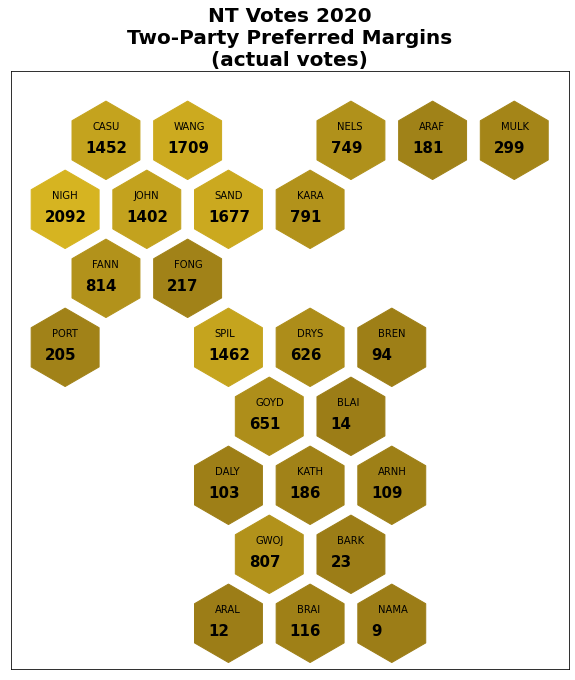

In [530]:
heading, selectedAnalysis = 'Two-Party Preferred Margins\n(actual votes)', 'TPPDifferenceInVotes' 
plotter(heading,selectedAnalysis)

You see just how fine - and bloated - some of those margins are when you look at them as a percentage of enrolled voters.

As low as 0.2% in Araluen and Namatjira. As high as 37% in Nightcliff.

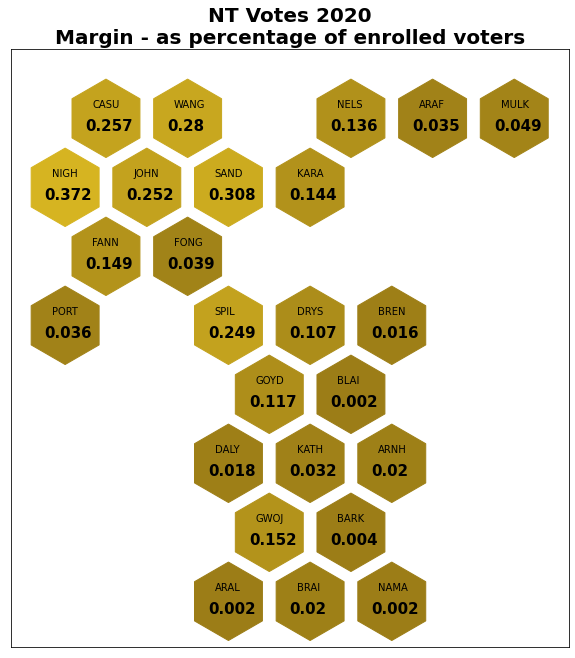

In [531]:
heading, selectedAnalysis = 'Margin - as percentage of enrolled voters', 'MarginEnrolledPC'
plotter(heading,selectedAnalysis)

## LOW VOTER TURNOUT

Many of the seats with tight margins also had low voter turnout. 

Turnout was less than 50 per cent in the newly created seat of Gwoja.

Three other remote seats had turnouts of less than 60 per cent. 

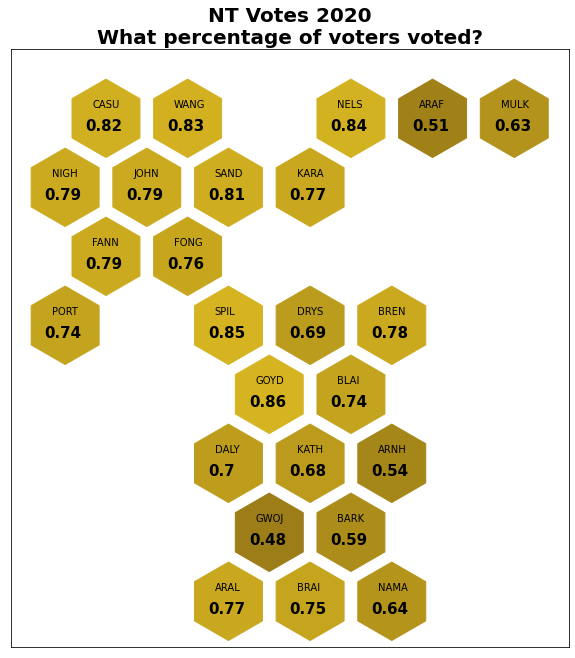

In [533]:
heading, selectedAnalysis  = 'What percentage of voters voted?', 'countedPC' 
plotter(heading,selectedAnalysis)

Contrast that with the situation in Darwin's rural area, where the NT's most highly engaged electorates can be found. 

Goyder and Nelson saw turnouts of 86 and 84 per cent. 

The latter had been held by an independent for nearly two decades (gerry Woods); the former was retained by an independent (Kezia Purick).

Voting across the built-up areas of the NT was generally in the high 70s/low 80s.

This all suggests that the NTEC - and the parties - are failing remote (and Aboriginal) voters. 

Since before the 2012 election, the NTEC has been trying to get voter turnout to at least 60 per cent at every seat. 

Whatever they are doing, it's not working.

## HIGH INFORMAL VOTES

There's another problem too - the NTEC and the parties are failing to even communicate properly with the remote and Aboriginal voters when they do turn up.

The informal vote (as a percentage of counted votes) was generally 2-3%, but was double that (or more) away from the cities of Darwin, Palmerston and Alice Springs. 

In Arnhem though, it was as high 8%.



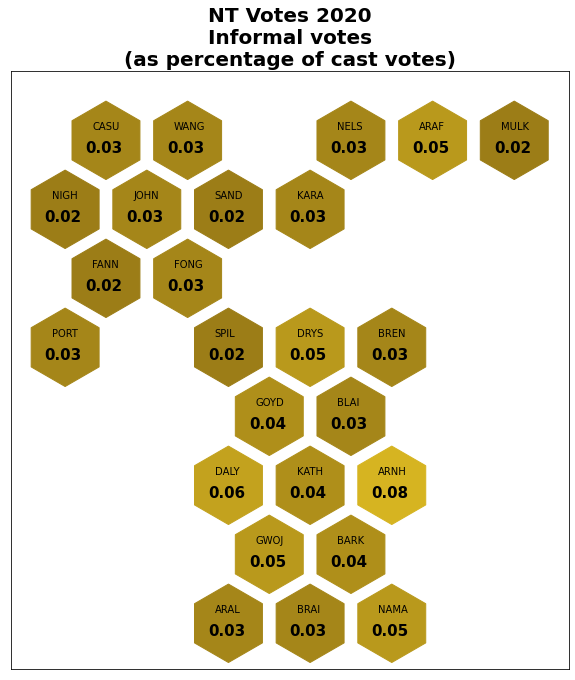

In [535]:
heading, selectedAnalysis = 'Informal votes\n(as percentage of cast votes)', 'informalOfCountedPC' 
plotter(heading,selectedAnalysis)

So the low turnout is even worse when you only count formal votes. 

Effective turnout drops to 46 per cent in Gwoja, 48 per cent in Arafura and 50 per cent in Arnhem.

It's a double whammy of low turnout and high informality. 

The NTEC really has its work cut out for it ensuring proper representation in remote communities.

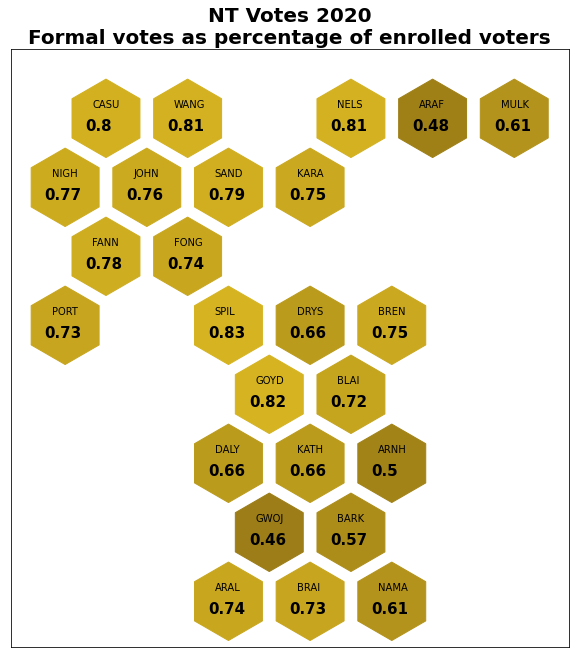

In [537]:
heading, selectedAnalysis = 'Formal votes as percentage of enrolled voters', 'formalOfEnrolledPC' 
plotter(heading,selectedAnalysis)

What are the parties doing about all this? It's not like these are safe seats. 

As we saw above, many seats with a low formal vote count can be decided by a handful of votes. 

Namatijira - where 39% of enrolled voters did not have a say - was decided by just 9 votes.

If the major parties are not throwing resources at these seats to try and win, they are mad.

## MAJOR PARTIES STRUGGLE OUTSIDE DARWIN

The major parties got just 40 per cent of the primary vote in Goyder. In the two Alice Springs seats, that figure was in the 50s. 

In the Darwin area, however, the major parties dominated the primary vote, with as much as 91% in Spillettt.

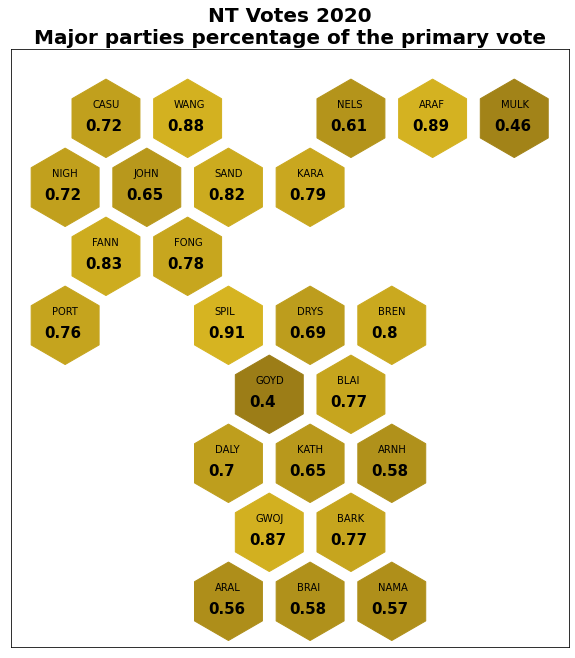

In [538]:
heading, selectedAnalysis = 'Major parties percentage of the primary vote', 'majorsPrimaryPC' 
plotter(heading,selectedAnalysis)

## TERRITORY ALLIANCE

The Territory Alliance was meant to be a real threat to take over as the NT's conservative voice. 

They won just one seat, and that was by 12 votes. 

In no seat did they beat the CLP in the primary vote. 

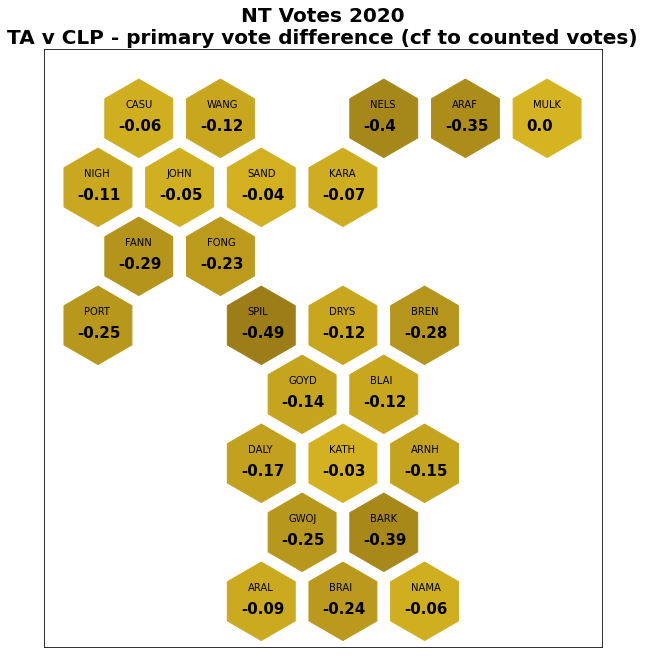

In [539]:
heading,selectedAnalysis = 'TA v CLP - primary vote difference (cf to counted votes)', 'taVSclpPC' 
plotter(heading,selectedAnalysis)

They did, however, outpoll the Greens - even in most of Darwin. 

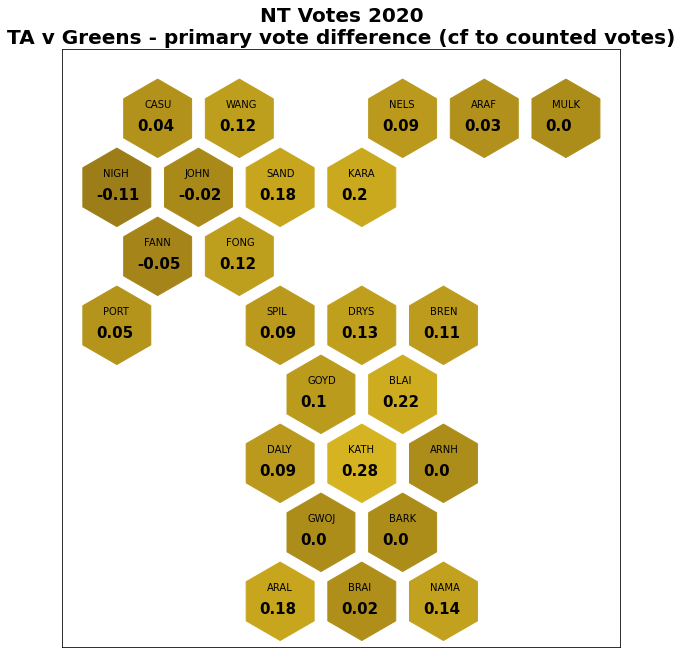

In [540]:
heading, selectedAnalysis = 'TA v Greens - primary vote difference (cf to counted votes)', 'taVSgrnPC' 
plotter(heading,selectedAnalysis)